In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pyreadr

from os.path import join
from scipy.stats import spearmanr

In [2]:

PROJ_DIR = "/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_SAaxis//"
DATA_DIR = "data/"
FIGS_DIR = "figures/"
OUTP_DIR = "output/"

In [5]:
thk_df = pd.read_csv(
    join(PROJ_DIR, OUTP_DIR, 'smri_thick_age-SA.csv'),
    index_col=0, header=0
)
var_df = pd.read_csv(
    join(PROJ_DIR, OUTP_DIR, 'rsfmri_var_age-SA.csv'),
    index_col=0, header=0
)
rni_df = pd.read_csv(
    join(PROJ_DIR, OUTP_DIR, 'dmri_rsirnigm_age-SA.csv'),
    index_col=0, header=0
)
rnd_df = pd.read_csv(
    join(PROJ_DIR, OUTP_DIR, 'dmri_rsirndgm_age-SA.csv'),
    index_col=0, header=0
)

In [46]:
# no need to do this for each of the SA/age dfs
# just showing you the structure of the data
rnd_df.head()

,SA_avg,age_avg,SA_rank
dmri_rsirndgm_cdk_pcclh,1886.682350,-0.025384,1
dmri_rsirndgm_cdk_cnlh,2815.554500,-0.016142,2
dmri_rsirndgm_cdk_cnrh,2960.284955,-0.017391,3
dmri_rsirndgm_cdk_pccrh,3064.538684,-0.029561,4
dmri_rsirndgm_cdk_lgrh,4769.030594,-0.022211,5


In [38]:
# read in each .Rda file and run correlations
result = pyreadr.read_r(join(PROJ_DIR, OUTP_DIR, 'residualized_rnd.Rda'))
residualized_rnd = result['Group1_residuals']

In [47]:
# this cell does the correlations

# first, make empty dataframes that we'll fill in the for loop
# for s-a axis loading corrs/alignment
sa_rnd_corrs = pd.DataFrame()
# and for age-10 map corrs/alignment
age_rnd_corrs = pd.DataFrame()

# now for each person (i),
for i in residualized_rnd.index:
    # we'll grab all their residual RND change scores
    temp1 = residualized_rnd.loc[i]
    # and rename the mini-dataframe, so that we know these are per-participant values
    temp1.name = 'ppt'
    # fix the index so that it matches the SA-axis rank 
    temp1.index = [var.split('.')[0] for var in temp1.index]
    # just grab the S-A axis rank column from rnd_df
    temp2 = rnd_df['SA_rank']
    # rename it so that we know these are per-region s-a axis values
    temp2.name = 'sa_axis'
    # put those two mini-dfs together to make life easier
    # this aligns them based on the index, which they share
    temp = pd.concat([temp1, temp2], axis=1)
    # correlate! using the new names we gave the two columns
    r,p = spearmanr(temp['ppt'], temp['sa_axis'])
    # save the r values to the 'r' column and the p-values to the 'p' column
    sa_rnd_corrs.at[i,'p'] = p
    sa_rnd_corrs.at[i,'r'] = r
    
    # and now do it all over for the age map
    temp2 = rnd_df['age_avg']
    temp2.name = 'age_effect'
    temp = pd.concat([temp1, temp2], axis=1)
    r,p = spearmanr(temp['ppt'], temp['age_effect'])
    
    age_rnd_corrs.at[i,'p'] = p
    age_rnd_corrs.at[i,'r'] = r
    
sa_rnd_corrs.to_csv(join(PROJ_DIR, OUTP_DIR, 'sa_rnd_corrs.csv'))
sa_rnd_corrs.to_csv(join(PROJ_DIR, OUTP_DIR, 'age_rnd_corrs.csv'))

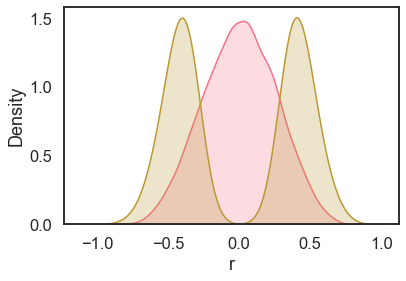

In [48]:
# set the plotting settings so our graphs are pretty
sns.set(context='talk', style='white', palette='husl')

# we're going to plot all the correlations
# and in a different color, the significant correlations @ p < 0.01
fig,ax = plt.subplots()
sns.kdeplot(sa_rnd_corrs['r'], fill=True, ax=ax)
sns.kdeplot(sa_rnd_corrs[sa_rnd_corrs['p'] < 0.01]['r'], fill=True, ax=ax)
fig.savefig(join(PROJ_DIR, FIGS_DIR, 'rnd_x_sa-axis.png'), bbox_inches='tight')

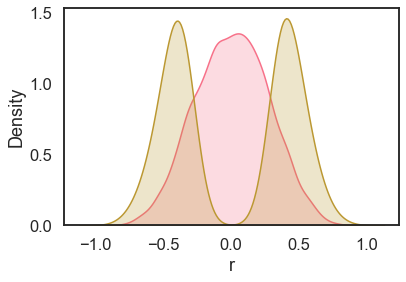

In [49]:
# same for age effect
fig,ax = plt.subplots()
sns.kdeplot(age_rnd_corrs['r'], fill=True, ax=ax)
sns.kdeplot(age_rnd_corrs[age_rnd_corrs['p'] < 0.01]['r'], fill=True, ax=ax)
fig.savefig(join(PROJ_DIR, FIGS_DIR, 'rnd_x_age.png'), bbox_inches='tight')